# IBM Stock Market Prediction Using LSTM with Pytorch
Ilesingha I.T.S.(IT21206078)

### Data Loading and Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load Data
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv(r"DATA/{}.csv".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

In [3]:
# Using different stocks and date range
symbols = ['ibm']
dates = pd.date_range('2015-01-02', '2016-12-31', freq='B') 
df = stocks_data(symbols, dates)

In [4]:
# Handle missing data using backward fill
df.fillna(method='pad', inplace=True)

# Adding moving average as a new feature
df['IBM_MA'] = df['ibm'].rolling(window=20).mean()
df.fillna(method='pad', inplace=True)

C:\Users\sulayako\AppData\Local\Temp\ipykernel_19600\1441335348.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)
C:\Users\sulayako\AppData\Local\Temp\ipykernel_19600\1441335348.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)


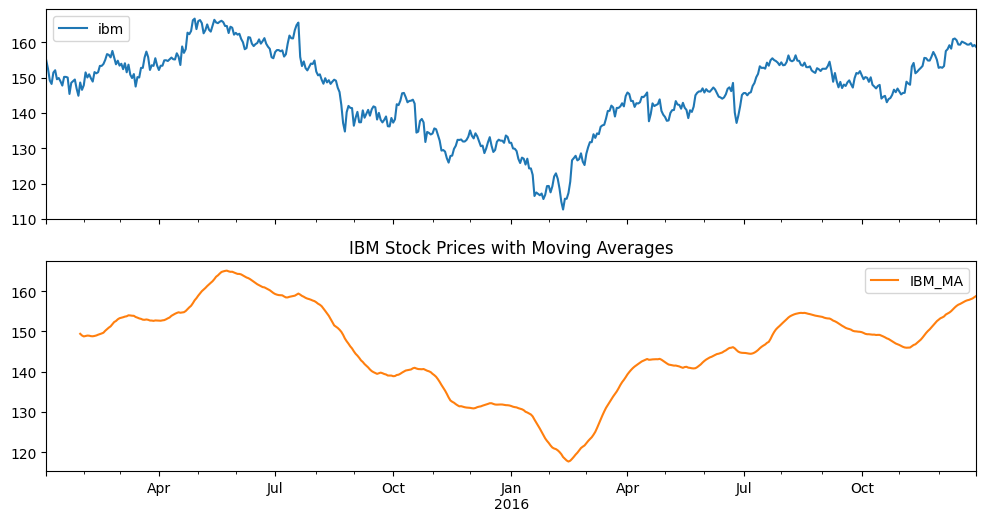

In [5]:
# Visualizing stock data
df.plot(figsize=(12, 6), subplots=True)
plt.title('IBM Stock Prices with Moving Averages')
plt.show()

In [6]:
df.head()

,ibm,IBM_MA
2015-01-02,154.933075,NaN
2015-01-05,152.495224,NaN
2015-01-06,149.206497,NaN
2015-01-07,148.231354,NaN
2015-01-08,151.453156,NaN


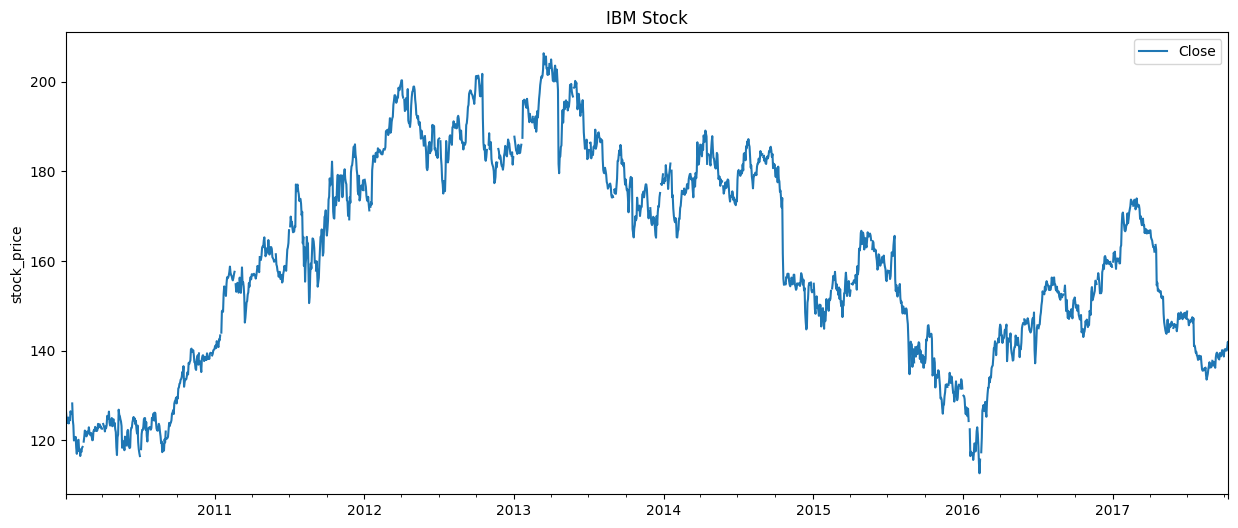

In [7]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("DATA/IBM.csv", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [8]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [9]:
df_ibm=df_ibm.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))
df_ibm

C:\Users\sulayako\AppData\Local\Temp\ipykernel_19600\1533307726.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ibm=df_ibm.fillna(method='ffill')


,Close
2010-01-04,-0.701889
2010-01-05,-0.734558
2010-01-06,-0.751914
2010-01-07,-0.761103
2010-01-08,-0.734558
...,...
2017-10-05,-0.410516
2017-10-06,-0.415416
2017-10-09,-0.396835
2017-10-10,-0.374171


### Data Preparation for LSTM

In [10]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [11]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

### Building the LSTM Model

In [13]:
# Define a custom LSTM model
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layers_count, output_dim):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layers_count = layers_count
        self.lstm = nn.LSTM(input_dim, hidden_dim, layers_count, batch_first=True, dropout=0.2)  # Added dropout
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layers_count, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layers_count, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 1
hidden_dim = 64  # Increased hidden units
layers_count = 3  # Added an additional LSTM layer
output_dim = 1

lstm_model = CustomLSTM(input_dim=input_dim, hidden_dim=hidden_dim, layers_count=layers_count, output_dim=output_dim)


### Loss Function and Optimizer

In [14]:
loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)
print(len(list(lstm_model.parameters())))
for i in range(len(list(lstm_model.parameters()))):
    print(list(lstm_model.parameters())[i].size())

CustomLSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
14
torch.Size([256, 1])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([1, 64])
torch.Size([1])


### Training the Model

In [15]:
# Train lstm_model
num_training_epochs = 150
hist = np.zeros(num_training_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_training_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #lstm_model.hidden = lstm_model.init_hidden()
    
    # Forward pass
    y_train_pred = lstm_model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between training_epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06045427918434143
Epoch  20 MSE:  0.027946151793003082
Epoch  30 MSE:  0.008758299052715302
Epoch  40 MSE:  0.00726968003436923
Epoch  50 MSE:  0.005655280314385891
Epoch  60 MSE:  0.005179178435355425
Epoch  70 MSE:  0.004799539223313332
Epoch  80 MSE:  0.004742463119328022
Epoch  90 MSE:  0.0046735056675970554
Epoch  100 MSE:  0.004446031525731087
Epoch  110 MSE:  0.004380873404443264
Epoch  120 MSE:  0.00412170821800828
Epoch  130 MSE:  0.003988034091889858
Epoch  140 MSE:  0.003825241234153509


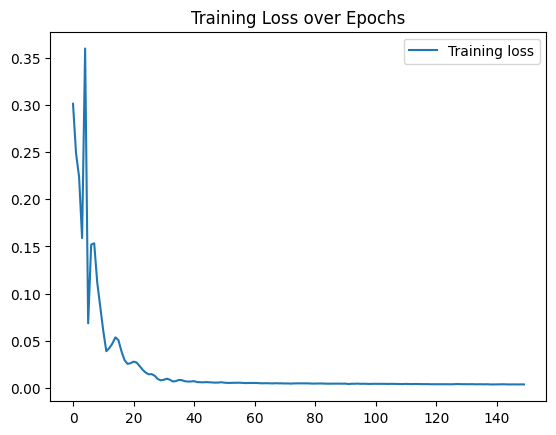

In [16]:
# Plotting the training loss
plt.plot(hist, label="Training loss")
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

### Making Predictions

In [17]:
np.shape(y_train_pred)

torch.Size([1574, 1])

In [18]:
# Make predictions on the test set
y_test_pred = lstm_model(x_test)

# Inverse the scaling
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())


### Evaluation and Metrics

In [19]:
# Evaluation metrics
trainScore = np.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
testScore = np.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
mae = mean_absolute_error(y_test[:, 0], y_test_pred[:, 0])
r2 = r2_score(y_test[:, 0], y_test_pred[:, 0])

print(f"Train Score: {trainScore:.2f} RMSE")
print(f"Test Score: {testScore:.2f} RMSE")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Train Score: 2.87 RMSE
Test Score: 2.14 RMSE
Mean Absolute Error (MAE): 1.60
R-squared (R2): 0.95


### Visualizing Predictions

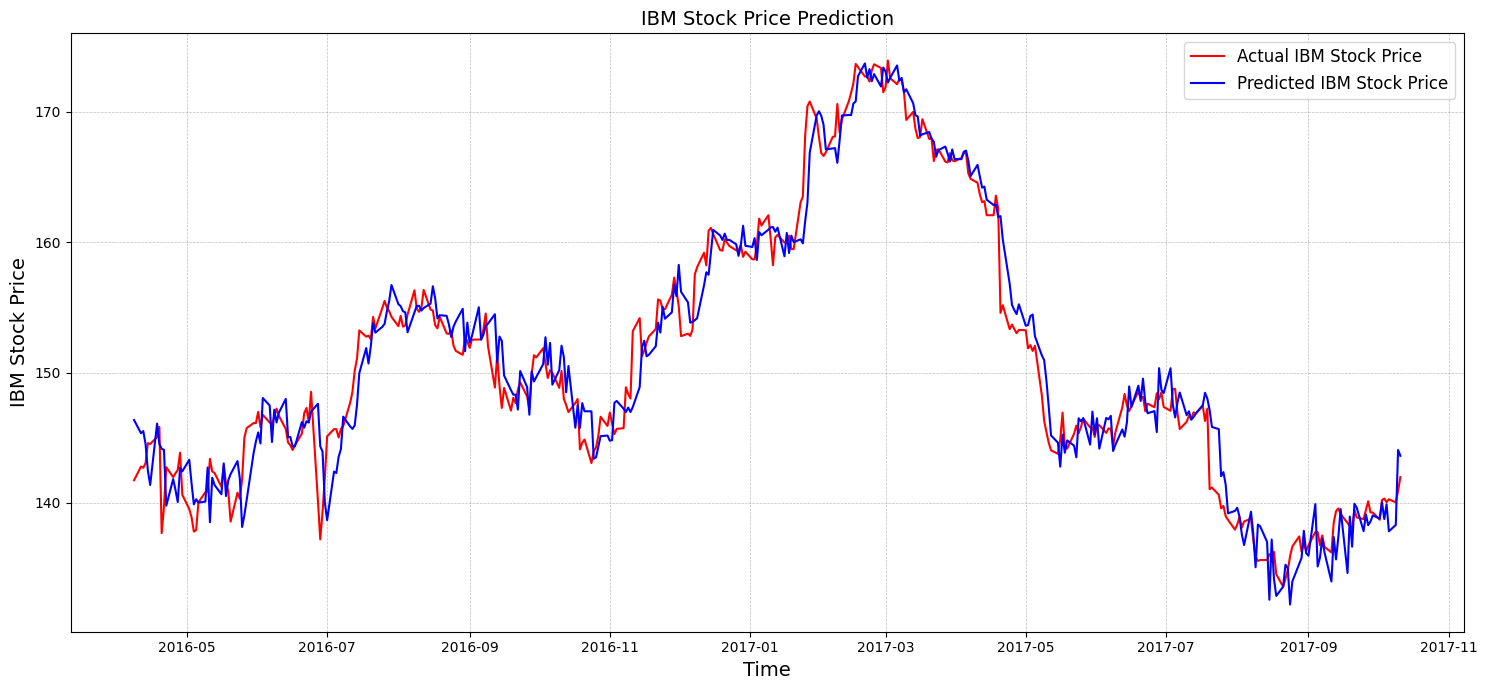

In [24]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 7))
axes.xaxis_date()
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test, color = 'r', label = 'Actual IBM Stock Price')
axes.plot(df_ibm[len(df_ibm)-len(y_test):].index, y_test_pred, color = 'b', label = 'Predicted IBM Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('IBM Stock Price Prediction', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.ylabel('IBM Stock Price', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Mean Squared Error (MSE): 4.58
Mean Absolute Error (MAE): 1.60
Root Mean Squared Error (RMSE): 2.14
R-squared (R2): 0.95
